# Thetis Calibration Script

## Section 0: Imports and global function definitions

In [ ]:
"""
ChatGPT Conversation:   https://chat.openai.com/c/ef545f4e-6aa6-4598-8c37-371934ac2cd9
                        https://chat.openai.com/c/55ac6d8d-8591-43f0-b7a5-d36e088d83aa
"""

import os
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages  # Add this import
from scipy.stats import zscore 

# Define the input and output directories
CALIBRATION_DATA_ROOT_DIR   = "C:/Users/bduffy2018/OneDrive - Florida Institute of Technology/School/Thesis/Experiments/Calibration/x-IMU3"
RAW_OUTPUT_PATH             = 'output/raw/'
PRELIMINARY_OUTPUT_PATH     = 'output/prelim/'
INTERMEDIATE_OUTPUT_PATH    = 'output/intermediate/'
FINAL_OUTPUT_PATH           = 'output/final/'


def RMSE(time_series: np.ndarray, ground_truth: float) -> float:
    """Returns the root-mean-square-error between a time series and a ground truth over the entire series

    Args:
        time_series (np.ndarray): The measurement time series
        ground_truth (float): The ground truth, "real" value that is compared against

    Returns:
        float: the RMSE between the time series and the ground truth
    """
    return np.sqrt(np.mean((time_series - ground_truth) ** 2))


def RMSE(arr1: np.ndarray, arr2: np.ndarray) -> float:
    """Returns the root-mean-square-error between two arrays

    Args:
        arr1 (np.ndarray): Input array 
        arr2 (np.ndarray): Input array

    Returns:
        float: the RMSE between the two arrays
    """
    return np.sqrt(np.mean((arr1 - arr2) ** 2))


def remove_large_changes(gyro_data, timestamps, threshold):
    diff = np.abs(np.diff(gyro_data, axis=0))  # Calculate absolute differences between consecutive rows
    large_changes = np.any(diff > threshold, axis=1)  # Check if any column has a large change
    
    if np.any(large_changes):
        # Find the index where the large change occurs
        change_index = np.argmax(large_changes)
        
        # Define a window size (adjust as needed)
        window_size = 10
        
        # Calculate the start and end indices of the subset to keep
        start_index = max(change_index - window_size, 0)
        end_index = min(change_index + window_size, len(gyro_data))
        
        # Extract the subset of data
        cleaned_data = gyro_data[start_index:end_index]
        cleaned_time = timestamps[start_index:end_index]
    else:
        cleaned_data = gyro_data
        cleaned_time = timestamps
    
    return cleaned_data, cleaned_time


def down_sample_average(data: np.array, n: int=2) -> np.array:
    """Down samples a data array by a factor.
    For example, if data is a time series sampled at 100 Hz, down_sample_average(data)
    will return the array averaged to 50 Hz.

    Args:
        data (np.array): The time series data to be modified
        n (int): the factor of reduction. 2 for half rate, 3 for third, etc. Defaults to 2

    Returns:
        np.array: The down sampled array
    """
    end = n * int(len(data)/n)
    return np.mean(data[:end].reshape(-1, n), axis=1)


# Initialize an empty list to store the sensor information
calibration_data = []


# Iterate through the directories
for sensor_dir in os.listdir(CALIBRATION_DATA_ROOT_DIR):
    sensor_name, axis, ground_truth_name = sensor_dir.split("_")
    
    # Process sensor names and units into a more ingestible format
    if sensor_name == "accel":
        sensor_name = "Accelerometer"
        y_label = "Acceleration"
        unit = "g"
        
        if axis == "x-axis":
            ground_truth_value = np.array([-1 * math.cos(math.radians(float(ground_truth_name))), -1 * math.sin(math.radians(float(ground_truth_name))), 0]) # X, Y, Z
        elif axis == "y-axis":
            ground_truth_value = np.array([1 * math.sin(math.radians(float(ground_truth_name))), 1 * math.cos(math.radians(float(ground_truth_name))), 0]) # X, Y, Z
        elif axis == "z-axis":
            ground_truth_value = np.array([-1 * math.cos(math.radians(float(ground_truth_name))), 0, -1 * math.cos(math.radians(float(ground_truth_name)))]) # X, Y, Z
            
        ground_truth_name += " degrees"
            
    elif sensor_name == "gyro":
        sensor_name = "Gyroscope"
        y_label = "Rotation Rate"
        unit = "deg/s"
        
        if axis == "x-axis":
            ground_truth_value = np.array([float(ground_truth_name), 0, 0]) # X, Y, Z
            ground_truth_name = f"{abs(ground_truth_value[0])} {unit} CCW" if ground_truth_value[0] < 0 else f"{abs(ground_truth_value[0])} {unit} CW"
        elif axis == "y-axis":
            ground_truth_value = np.array([0, float(ground_truth_name), 0]) # X, Y, Z
            ground_truth_name = f"{abs(ground_truth_value[1])} {unit} CCW" if ground_truth_value[1] < 0 else f"{abs(ground_truth_value[1])} {unit} CW"
        elif axis == "z-axis":
            ground_truth_value = np.array([0, 0, float(ground_truth_name)]) # X, Y, Z
            ground_truth_name = f"{abs(ground_truth_value[2])} {unit} CCW" if ground_truth_value[2] < 0 else f"{abs(ground_truth_value[2])} {unit} CW"
            
    elif sensor_name == "mag":
        sensor_name = "Magnetometer"
        y_label = "Magnetic Field"
        unit = "uT"
        MAGNETIC_FIELD_MAGNITUDE = 4.6 # uT, magnitude of the magnetic field measured at time of calibration
        
        ground_truth_value = float(ground_truth_name)
        MAG_FIELD_COS = -MAGNETIC_FIELD_MAGNITUDE*math.cos(ground_truth_value) # Value of axis that is pointing at 0-deg at start of test
        MAG_FIELD_SIN = -MAGNETIC_FIELD_MAGNITUDE*math.sin(ground_truth_value) # Value of axis that is pointing at 270-deg at start of test
        
        if axis == "x-axis": # X-axis vertical, Earth component 0
            ground_truth_value = np.array([0, MAG_FIELD_SIN, MAG_FIELD_COS])
        elif axis == "y-axis": # Y-axis vertical, Earth component 0
            ground_truth_value = np.array([MAG_FIELD_COS, 0, MAG_FIELD_SIN])
        elif axis == "z-axis": # Z-axis vertical, Earth component 0
            ground_truth_value = np.array([MAG_FIELD_SIN, MAG_FIELD_COS, 0]) 
            
        ground_truth_name += " degrees"
        
    # Initialize a dictionary to store the sensor information
    calibration_dataset = {
        "sensor_name": sensor_name,
        "axis": axis[0].capitalize(),
        "ground_truth_name": ground_truth_name,
        "ground_truth_value": ground_truth_value,
        "devices": [],
        "device_deviation": None,
        "y_label": y_label,
        "unit": unit,
        "output_name": sensor_dir
    }

    # Iterate through the device directories
    device_dir = os.path.join(CALIBRATION_DATA_ROOT_DIR, sensor_dir)
    for device_dir_name in os.listdir(device_dir):
        # print(device_dir_name.split())
        device_name = device_dir_name.split()[0]
        inertial_csv_path = os.path.join(device_dir, device_dir_name, "Inertial.csv")
        magnetic_csv_path = os.path.join(device_dir, device_dir_name, "Magnetometer.csv")
        
        # Append the device information to the sensor dictionary
        calibration_dataset["devices"].append({
            "device_name": device_name,
            "inertial_csv_path": inertial_csv_path,
            "magnetic_csv_path": magnetic_csv_path,
            "raw_time": None,
            "raw_data": None,
            "cleaned_time": None,
            "cleaned_data": None,
            "window_start": None,
            "window_end": None,
            "windowed_time": None,
            "windowed_data": None,
            "ground_truth_deviation": None
        })

    # Append the sensor dictionary to the list
    calibration_data.append(calibration_dataset)

## Section 1: Windowing the Raw Data
Here, we will process the raw data into windows that are more usable for future calculations. We will also create plots of the raw data with the windows represented.

In [ ]:
# Define the size of series windows
SAMPLE_RATE         = 50                            # Data captured at ~F Hz sample rate
WINDOW_SIZE_SEC     = 15                            # Capture ~N-seconds of data
WINDOW_SIZE = SAMPLE_RATE * WINDOW_SIZE_SEC # Calculate number of indexes required for the window

for calibration_dataset in calibration_data:
    
    if calibration_dataset["sensor_name"] == "Magnetometer": # Skip magnetometer datasets
        continue
    
    # Determine the column number based on axis
    if calibration_dataset["axis"] == "X":
        ax_num = 0
    elif calibration_dataset["axis"] == "Y":
        ax_num = 1
    elif calibration_dataset["axis"] == "Z":
        ax_num = 2
        
    for device in calibration_dataset["devices"]:
        
        # ========================================
        # == Clean The Raw Data For Each Device ==
        # ========================================
        
        # Load the CSV data into a DataFrame
        df = pd.read_csv(device["inertial_csv_path"])
        df["Timestamp (us)"] = pd.to_datetime(df['Timestamp (us)'], unit='us')
        df.set_index("Timestamp (us)", inplace=True)
        
        if device['device_name'] == "x-IMU3": # Downsample x-IMU3 data to 50 Hz
            df = df.resample('20L').mean()
        
        # Save data to device dictionary before modification
        time_df = df.index
        data_df = df[[f"{calibration_dataset['sensor_name']} X ({calibration_dataset['unit']})",
                      f"{calibration_dataset['sensor_name']} Y ({calibration_dataset['unit']})",
                      f"{calibration_dataset['sensor_name']} Z ({calibration_dataset['unit']})"]]
        
        device["raw_time"] = time_df.to_numpy()
        device["raw_data"] = data_df.to_numpy()
        
        df = df[(np.abs(zscore(data_df.iloc[:, ax_num], nan_policy='omit')) < 3)] # Remove outliers according to Z-score
                        
        timestamps = df.index.to_numpy()
        data = df[[f"{calibration_dataset['sensor_name']} X ({calibration_dataset['unit']})",
                   f"{calibration_dataset['sensor_name']} Y ({calibration_dataset['unit']})",
                   f"{calibration_dataset['sensor_name']} Z ({calibration_dataset['unit']})"]].to_numpy()
                                
        device["cleaned_time"] = timestamps
        device["cleaned_data"] = data
        
        device["window_start"]  = int(len(data)/2) - int(WINDOW_SIZE/2)
        device["window_end"]    = device["window_start"] + WINDOW_SIZE
        device["windowed_time"] = timestamps[device["window_start"]:device["window_end"]]
        device["windowed_data"] = data[device["window_start"]:device["window_end"], :]
    
    # ======================================================
    # == Create Plots of the Raw Data with Windows Marked ==
    # ======================================================
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained', sharey='row')
    
    # Pull data into temporary variables
    thetis_device = calibration_dataset["devices"][0]
    ximu3_device = calibration_dataset["devices"][1]
    
    thetis_cleaned_time = thetis_device["cleaned_time"]
    thetis_cleaned_data = thetis_device["cleaned_data"]
    ximu3_cleaned_time = ximu3_device["cleaned_time"]
    ximu3_cleaned_data = ximu3_device["cleaned_data"]
    
    thetis_windowed_time = thetis_device["windowed_time"]
    thetis_windowed_data = thetis_device["windowed_data"]
    ximu3_windowed_time = ximu3_device["windowed_time"]
    ximu3_windowed_data = ximu3_device["windowed_data"]
    
    # Plot onto respective subplots
    axs[0][0].plot(thetis_cleaned_time, thetis_cleaned_data[:, ax_num])
    axs[0][1].plot(ximu3_cleaned_time,  ximu3_cleaned_data[:, ax_num])
    axs[1][0].plot(thetis_windowed_time, thetis_windowed_data[:, ax_num])
    axs[1][1].plot(ximu3_windowed_time, ximu3_windowed_data[:, ax_num])

    # Plot the window bounds
    axs[0][0].axvline(x=thetis_cleaned_time[thetis_device["window_start"]], color='g', linestyle='--')
    axs[0][0].axvline(x=thetis_cleaned_time[thetis_device["window_end"]], color='g', linestyle='--')
    axs[0][1].axvline(x=ximu3_cleaned_time[ximu3_device["window_start"]], color='g', linestyle='--')
    axs[0][1].axvline(x=ximu3_cleaned_time[ximu3_device["window_end"]], color='g', linestyle='--')
    axs[0][0].legend(["Measurements", "Window Bounds"])
    
    # Plot the ground truth value
    axs[1][0].axhline(y=calibration_dataset['ground_truth_value'][ax_num], color='r', linestyle='--')
    axs[1][1].axhline(y=calibration_dataset['ground_truth_value'][ax_num], color='r', linestyle='--')
    axs[1][0].legend(["Measurements", "Ground Truth Value"])
    
    # Set individual plot title
    axs[0][0].set_title("Thetis | Clean")
    axs[0][1].set_title("x-IMU3 | Clean")
    axs[1][0].set_title("Thetis | Window")
    axs[1][1].set_title("x-IMU3 | Window")
    
    # Add a label for the RMSE values
    thetis_device['ground_truth_deviation'] = RMSE(thetis_device["windowed_data"][:, ax_num], calibration_dataset['ground_truth_value'][ax_num])
    ximu3_device['ground_truth_deviation'] = RMSE(ximu3_device["windowed_data"][:, ax_num], calibration_dataset['ground_truth_value'][ax_num])
    fig.text(0.07, 0.48, f"Thetis RMSE: {thetis_device['ground_truth_deviation']:0.3f} {calibration_dataset['unit']}", color='blue', va='center', ha='left')
    fig.text(1.0, 0.48, f"x-IMU3 RMSE: {ximu3_device['ground_truth_deviation']:0.3f} {calibration_dataset['unit']}", color='blue', va='center', ha='right')
    
    # Calculate deviation of Thetis from x-IMU3 window data
    calibration_dataset["device_deviation"] = RMSE(thetis_device["windowed_data"][:, ax_num], ximu3_device["windowed_data"][:, ax_num])
    fig.text(0.5, 0.95, f"Thetis Deviation from x-IMU3: {calibration_dataset['device_deviation']:0.3f} {calibration_dataset['unit']}", va='center', ha='center')     
        
    # Set the title and labels for the whole figure
    fig.suptitle(f"{calibration_dataset['sensor_name']} {calibration_dataset['axis']} | {calibration_dataset['ground_truth_name']}")
    
    fig.supxlabel("Timestamp [hh:mm:ss] (since system start)")
    fig.supylabel(f"{calibration_dataset['y_label']} [{calibration_dataset['unit']}]")
    
    # Save figure to files
    # plt.show()
    FIG_OUTPUT_PATH = RAW_OUTPUT_PATH + f"raw_{calibration_dataset['output_name']}.png"
    if not os.path.exists(FIG_OUTPUT_PATH): # Check if output already exists to save execution time
        fig.savefig(FIG_OUTPUT_PATH)
    
    # Close the figure to save memory
    plt.close(fig)

## Section 2: Plot MSE as a Function of Ground Truth
Create two figures with three plots each. One figure for accelerometer, one for gyroscope. Each plot will be MSE as a function of the test value. One plot will be x-IMU3 wrt ground truth, the second plot will be Thetis wrt x-IMU3, and the final plot will be Thetis wrt the ground truth.

In [ ]:
# Create figure for accelerometer error
fig_accel, axes_accel = plt.subplots(1, 3, figsize=(18, 4), layout='constrained', sharey=True, sharex=True)

# Create figure for gyroscope error
fig_gyro, axes_gyro = plt.subplots(1, 3, figsize=(18, 4), layout='constrained', sharey=True, sharex=True)

calibration_errors = [{
    "sensor_name": dataset["sensor_name"],
    "axis": dataset["axis"],
    "ground_truth_value": float(dataset["ground_truth_name"].split(" ")[0]) if dataset["sensor_name"] == "Accelerometer" else dataset["ground_truth_value"], 
    "thetis_ximu3_deviation": dataset["device_deviation"], 
    "thetis_ground_deviation": dataset["devices"][0]["ground_truth_deviation"], 
    "ximu3_ground_deviation": dataset["devices"][1]["ground_truth_deviation"]}
    for dataset in calibration_data]
print(calibration_errors)

def sort_ascending(x_values, y_values):
    combined = list(zip(x_values, y_values))
    sorted_combined = sorted(combined, key=lambda x: x[0])
    return zip(*sorted_combined)

# ===============================
# == Plot Accelerometer Errors ==
# ===============================

def get_axis_num(axis):
    if axis == "X":
        return 0
    elif axis == "Y":
        return 1
    elif axis == "Z":
        return 2
    
for i, ax in enumerate(axes_accel):
    if i == 0: # x-IMU3 w.r.t Ground Truth
        for axis in ["X", "Y", "Z"]:
            x_values = [item["ground_truth_value"] for item in calibration_errors if item["sensor_name"] == "Accelerometer" and item["axis"] == axis]
            errors = [item["ximu3_ground_deviation"] * 1e3 for item in calibration_errors if item["sensor_name"] == "Accelerometer" and item["axis"] == axis]
            x_sorted, errors_sorted = sort_ascending(x_values, errors)
            ax.plot(x_sorted, errors_sorted, label=axis)
        ax.set_title("x-IMU3 w.r.t Ground Truth")

    if i == 1: # Thetis w.r.t x-IMU3
        for axis in ["X", "Y", "Z"]:
            x_values = [item["ground_truth_value"] for item in calibration_errors if item["sensor_name"] == "Accelerometer" and item["axis"] == axis]
            errors = [item["thetis_ximu3_deviation"] * 1e3 for item in calibration_errors if item["sensor_name"] == "Accelerometer" and item["axis"] == axis]
            x_sorted, errors_sorted = sort_ascending(x_values, errors)
            ax.plot(x_sorted, errors_sorted, label=axis)
        ax.set_title("Thetis w.r.t x-IMU3")
            
    if i == 2: # Thetis w.r.t Ground Truth
        for axis in ["X", "Y", "Z"]:
            x_values = [item["ground_truth_value"] for item in calibration_errors if item["sensor_name"] == "Accelerometer" and item["axis"] == axis]
            errors = [item["thetis_ground_deviation"] * 1e3 for item in calibration_errors if item["sensor_name"] == "Accelerometer" and item["axis"] == axis]
            x_sorted, errors_sorted = sort_ascending(x_values, errors)
            ax.plot(x_sorted, errors_sorted, label=axis)
        ax.set_title("Thetis w.r.t Ground Truth")
    ax.grid()
    ax.legend()
    
fig_accel.suptitle("Accelerometer Error")
fig_accel.supylabel("Error (mg)")
fig_accel.supxlabel("Angle (deg)")

# ===========================
# == Plot Gyroscope Errors ==
# ===========================

for i, ax in enumerate(axes_gyro):
    if i == 0: # x-IMU3 w.r.t Ground Truth
        for axis in ["X", "Y", "Z"]:
            x_values = [item["ground_truth_value"][get_axis_num(axis)] for item in calibration_errors if item["sensor_name"] == "Gyroscope" and item["axis"] == axis]
            errors = [item["ximu3_ground_deviation"] for item in calibration_errors if item["sensor_name"] == "Gyroscope" and item["axis"] == axis]
            x_sorted, errors_sorted = sort_ascending(x_values, errors)
            ax.plot(x_sorted, errors_sorted, label=axis)
        ax.set_title("x-IMU3 w.r.t Ground Truth")

    if i == 1: # Thetis w.r.t x-IMU3
        for axis in ["X", "Y", "Z"]:
            x_values = [item["ground_truth_value"][get_axis_num(axis)] for item in calibration_errors if item["sensor_name"] == "Gyroscope" and item["axis"] == axis]
            errors = [item["thetis_ximu3_deviation"] for item in calibration_errors if item["sensor_name"] == "Gyroscope" and item["axis"] == axis]
            x_sorted, errors_sorted = sort_ascending(x_values, errors)
            ax.plot(x_sorted, errors_sorted, label=axis)
        ax.set_title("Thetis w.r.t x-IMU3")
            
    if i == 2: # Thetis w.r.t Ground Truth
        for axis in ["X", "Y", "Z"]:
            x_values = [item["ground_truth_value"][get_axis_num(axis)] for item in calibration_errors if item["sensor_name"] == "Gyroscope" and item["axis"] == axis]
            errors = [item["thetis_ground_deviation"] for item in calibration_errors if item["sensor_name"] == "Gyroscope" and item["axis"] == axis]
            x_sorted, errors_sorted = sort_ascending(x_values, errors)
            ax.plot(x_sorted, errors_sorted, label=axis)
        ax.set_title("Thetis w.r.t Ground Truth")
    ax.tick_params(axis='y')
    ax.grid()
    ax.legend()
    
fig_gyro.suptitle("Gyroscope Error")
fig_gyro.supylabel("Error (deg/sec)")
fig_gyro.supxlabel("Angular Velocity (deg/sec)")

# ===========================
# == Save Figures to Files ==
# ===========================

# plt.show() # Debug

FIG_OUTPUT_PATH = PRELIMINARY_OUTPUT_PATH + "prelim_accel.png"
if not os.path.exists(FIG_OUTPUT_PATH): # Check if output already exists to save execution time
    fig_accel.savefig(FIG_OUTPUT_PATH)
    
FIG_OUTPUT_PATH = PRELIMINARY_OUTPUT_PATH + "prelim_gyro.png"
if not os.path.exists(FIG_OUTPUT_PATH): # Check if output already exists to save execution time
    fig_gyro.savefig(FIG_OUTPUT_PATH)

# Close the figures to save memory
plt.close(fig_accel)
plt.close(fig_gyro)

## Section 3: Calculate Calibration Parameters

In order to calibrate a MARG array, we need to create a model of the data. For the accelerometer and gyroscope, we can create an inertial model defined as:

$$
\vec{i}_c=MS(\vec{i}_u-\vec{b}) \\
\begin{align*}
\\
\text{where } & \vec{i}_C \text{ is the calibrated inertial measurements,} \\ 
& M \text{ is the misalignment matrix,} \\
& S \text{ is the sensitivity identity matrix,} \\
& \vec{i}_u \text{ is the uncalibrated inertial measurements, and} \\
& \vec{b} \text{ is the bias or offset vector}
\end{align*}
$$

The three calibration values, $M$, $S$, $b$, represent a set of correction factors that make the measured values more accurate. The inertial measurement is generalized here to represent either accelerometer or gyroscope data. Each sensor will have its own set of the calibration values.

### Bias Vector

The bias, or offset, vector is the average of the inertial readings while the sensor is in a stable, known orientation. For example, when the gyroscope is at rest, we would expect the measurement output to be $[0,0,0] \text{ [deg/sec]}$. However, we may measure an average of $[0.89, -0.66, 0.31] \text{ [deg/sec]}$ instead. By subtracting this bias vector from the measurements, we eliminate any unintentional offset from our readings. The bias can be calculated using the equation below:

$$
\vec{b}_g = \frac{1}{N} \sum_{i=0}^N{\vec{g}_n} \\
\begin{align*}
\\
\text{where } & \vec{b}_g \text{ is the bias vector,} \\
& N \text{ is the number of collected samples to average, and} \\
& \vec{g}_n \text{ is the n-th uncalibrated gyroscope measurement vector in the dataset}
\end{align*}
$$

For accelerometers, the bias is calculated differently. Each measurement axis must be exposed to ±1g of acceleration by placing the instrument vertical on each of the measurement axes in both the positive and negative directions. The bias for each axis can then be determined by taking the average value as shown below:

$$
\vec{b}_a = \frac{1}{2} \left[ \frac{1}{N}\sum_{n=0}^N{\vec{a}_{n,+g}} + \frac{1}{M}\sum_{m=0}^M{\vec{a}_{m_-g}} \right] \\

\begin{align*}
\\ \text{where } & b_a \text{ is the bias vector,} \\
& N \text{ is the number of samples taken in the +1g orientation,} \\
& a_{+g} \text{ is the average axis measurement when exposed to +1g, and}\\
& M \text{ is the number of samples taken in the -1g orientation,} \\
& a_{-g} \text{ is the average axis measurement when exposed to -1g}
\end{align*}
$$

### Sensitivity Matrix

The sensitivity matrix is a diagonal matrix that accounts for minor errors with variations in process and material. This can make each uniaxial sensor in a triaxial array sense the environment slightly differently. While bias covers this area when at rest or in specific orientations, the sensitivity error will change depending on the motion and orientation. To account for this, we need to expose each sensor to a known reference stimulus and calculate a sensitivity value based on the average magnitude of the measurement vector during that time. For a gyroscope, this value can be an arbitrary, but constant, rotation rate, $\omega$. For an accelerometer, this value will be ±1g. The equations for each gyroscope and accelerometer axis are provided below:

$$
s_{g, \omega} = \frac{\lVert g_{+\omega}\rVert + \lVert g_{-\omega}\rVert}{2\omega} \\
\begin{align*}
\\ \text{where } & s_{g,\omega} \text{ is the sensitivity value for each gyroscope axis when exposed to } \omega , \\
& g_{+\omega } \text{ is the average gyroscope axis reading whe exposed to +} \omega ,\\
& g_{-\omega } \text{ is the average gyroscope axis reading whe exposed to -} \omega , \text{ and} \\
& \omega \text{ is the reference roation rate}
\end{align*}
$$

$$
s_{a, g} = \frac{\lVert a_{+g} \rVert + \lVert a_{-g} \rVert}{2} \\
\begin{align*}
\\ \text{where } & s_{a,g} \text{ is the sensitivity value for each axis when exposed to 1g,} \\
& a_{+g} \text{ is the average axis measurement when exposed to +1g, and} \\
& a_{-g} \text{ is the average axis measurement when exposed to -1g}
\end{align*}
$$

After calculating these values for each axis, we can form the sensitivity matrix for the gyroscope and accelerometer like so:

$$
S_g = 
\begin{bmatrix}
s_{g,x} & 0 & 0 \\
0 & s_{g,y} & 0 \\
0 & 0 & s_{g,z}
\end{bmatrix} 
$$

$$
S_a =
\begin{bmatrix}
s_{a,x} & 0 & 0 \\
0 & s_{a,y} & 0 \\
0 & 0 & s_{a,z}
\end{bmatrix}
$$

While this calibration value accounts for some of the intrinsic sensor error, it does not account for axes misalignment or non-orthogonality within the sensor. To accomplish this, we must incorporate the misalignment matrix.

### Misalignment Matrix

The misalignment matrix is the final, but most complex, calibration value that we can calculate for the inertial sensors. It reduces error from multiple sources such as non-orthogonality between the measurement axes, the misalignment from the measurement axes to the actual sensor packaging, and misalignment from the package onto the application board. In order to calculate the misalignment matrix, we must consider it as the solution to a non-linear problem. First, we must define an objective function for the solution space. Since the goal of the misalignment matrix is to reduce error, then we can define the objective function as the Root Mean Square Error (RMSE) of the measurement vector, the misalignment vector, and the reference vector:

$$
RMSE = \sqrt{\frac{1}{N}\sum_{n=0}^N{\|{\vec{i}_{n,u} \cdot M^* -\vec{i}_{n,ref}\|}^2}} \\

\begin{align*}
\\ \text{where } & N \text{ is the number of samples in the dataset,} \\
& \vec{i}_{n,u} \text{ is the n-th uncalibrated measurement vector with the bias removed,} \\
& M^* \text{ is the guessed 3-by-3 matrix that corrects $i_{n,u}$ to be near $i_{ref}$, and } \\
& \vec{i}_{ref} \text{ is the expected reference stimulus vector for the measurement}
\end{align*}
$$

Then, given a dataset of measurement vectors and their expected reference vectors, we can use a non-liner solver to determine the value of $M^*$. This can be done using the `scipy.optimize.minimize` toolbox which black boxes the process, but provides an easy to work with output for future processing. Assuming the sensitivity was not removed from the measurement signal, the $M^*$ matrix happens to include it as its diagonal. By extracting the diagonal and normalizing the original matrix, we are left with the sensitivity and misalignment matrix calibration values.

$$
S = \text{diag}(M^*) \\
M=M^* \cdot S^{-1}
$$

We can now apply the misalignment matrix, sensitivity matrix, and bias vector to the sensor readings according to the model above. This should yield outputs that are close to the real values, which is examined in the next section.

In [ ]:
# ==========================================
# == Calculate Bias for the Accelerometer ==
# ==========================================

accel_data_p1g_x = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Accelerometer" and dataset["axis"] == "X" and dataset["ground_truth_value"][0] == 1.0])
accel_data_p1g_y = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Accelerometer" and dataset["axis"] == "Y" and dataset["ground_truth_value"][1] == 1.0])
accel_data_p1g_z = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Accelerometer" and dataset["axis"] == "Z" and dataset["ground_truth_value"][2] == 1.0])
accel_data_m1g_x = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Accelerometer" and dataset["axis"] == "X" and dataset["ground_truth_value"][0] == -1.0])
accel_data_m1g_y = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Accelerometer" and dataset["axis"] == "Y" and dataset["ground_truth_value"][1] == -1.0])
accel_data_m1g_z = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Accelerometer" and dataset["axis"] == "Z" and dataset["ground_truth_value"][2] == -1.0])

p1g_end = min((len(accel_data_p1g_x), len(accel_data_p1g_y), len(accel_data_p1g_z)))
accel_data_p1g = np.vstack((accel_data_p1g_x[:p1g_end], accel_data_p1g_y[:p1g_end], accel_data_p1g_z[:p1g_end]))
m1g_end = min((len(accel_data_m1g_x), len(accel_data_m1g_y), len(accel_data_m1g_z)))
accel_data_m1g = np.vstack((accel_data_m1g_x[:m1g_end], accel_data_m1g_y[:m1g_end], accel_data_m1g_z[:m1g_end]))
# print(accel_data_p1g)
# print(accel_data_m1g)

accel_bias = (np.mean(accel_data_p1g, axis=0) + np.mean(accel_data_m1g, axis=0)) / 2
print(f"Accelerometer bias: {accel_bias}") 

# ======================================
# == Calculate Bias for the Gyroscope ==
# ======================================

gyro_data_0_x = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Gyroscope" and dataset["axis"] == "X" and dataset["ground_truth_value"][0] == 0.0])
gyro_data_0_y = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Gyroscope" and dataset["axis"] == "Y" and dataset["ground_truth_value"][1] == 0.0])
gyro_data_0_z = np.concatenate([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Gyroscope" and dataset["axis"] == "Z" and dataset["ground_truth_value"][2] == 0.0])

gyro_0_end = min((len(gyro_data_0_x), len(gyro_data_0_y), len(gyro_data_0_z)))
gyro_data_0 = np.vstack((gyro_data_0_x[:gyro_0_end], gyro_data_0_y[:gyro_0_end], gyro_data_0_z[:gyro_0_end]))
# print(gyro_data_0) # DEBUG

gyro_bias = np.mean(gyro_data_0, axis=0)
print(f"Gyroscope bias: {gyro_bias}")

# =============================
# == Pull Data from Datasets ==
# =============================

accel_data = np.vstack([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Accelerometer"])
accel_ref = np.vstack([np.ones(dataset["devices"][0]["cleaned_data"].shape) * dataset["ground_truth_value"] for dataset in calibration_data if dataset["sensor_name"] == "Accelerometer"])
# print(accel_data.shape) # Debug
# print(accel_ref.shape) # Debug

gyro_data = np.vstack([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Gyroscope"])
gyro_ref = np.vstack([np.ones(dataset["devices"][0]["cleaned_data"].shape) * dataset["ground_truth_value"] for dataset in calibration_data if dataset["sensor_name"] == "Gyroscope"])
# print(gyro_data.shape) # Debug
# print(gyro_ref.shape) # Debug

# ===================================
# == Remove Bias from Data Signals ==
# ===================================

for i in range(accel_data.shape[0]):
    accel_data[i] - accel_bias
    
for i in range(gyro_data.shape[0]):
    gyro_data[i] - gyro_bias

# =====================================================
# == Calculate Misalignment and Sensitivity Matrices ==
# =====================================================

# Define the loss functions
def rmse_loss_accel(M_flattened):
    M = M_flattened.reshape((3, 3))
    total_loss = 0.0
    
    for i in range(accel_data.shape[0]):
        difference = np.dot(accel_data[i], M) - accel_ref[i]
        mse = np.linalg.norm(difference)**2
        total_loss += mse
    
    return np.sqrt(total_loss)

def rmse_loss_gyro(M_flattened):
    M = M_flattened.reshape((3, 3))
    total_loss = 0.0
    
    for i in range(gyro_data.shape[0]):
        difference = np.dot(gyro_data[i], M) - gyro_ref[i]
        mse = np.linalg.norm(difference)**2
        total_loss += mse
    
    return np.sqrt(total_loss)

# Initial guess for M
initial_M_accel = np.zeros((3, 3))
initial_M_gyro = np.zeros((3, 3))

from scipy.optimize import minimize

# Perform optimization for each loss function
result_accel = minimize(rmse_loss_accel, initial_M_accel.flatten(), method='SLSQP')
result_gyro = minimize(rmse_loss_gyro, initial_M_gyro.flatten(), method='SLSQP')

# Reshape the results to get the 3x3 matrices M
optimal_M_accel = result_accel.x.reshape((3, 3))
optimal_M_gyro = result_gyro.x.reshape((3, 3))

# Function to extract diagonal matrix and return normalized M and diagonal
def extract_diagonal_matrix(matrix):
    diagonal = np.diag(matrix)
    normalized_M = matrix / diagonal
    return normalized_M, diagonal

# Extract diagonal and normalize for each optimization result
misalignment_accel, sensitivity_accel = extract_diagonal_matrix(optimal_M_accel)
misalignment_gyro, sensitivity_gyro = extract_diagonal_matrix(optimal_M_gyro)

# Report the results
print("Optimal M matrix (accelerometer):")
print(optimal_M_accel)

print("Sensitivity vector (accelerometer):")
print(sensitivity_accel)

print("Misalignment matrix (accelerometer):")
print(misalignment_accel)

print("Optimal M matrix (gyroscope):")
print(optimal_M_gyro)

print("Sensitivity vector (gyroscope):")
print(sensitivity_gyro)

print("Misalignment matrix (gyroscope):")
print(misalignment_gyro)

# Section 3: Magnetometer Hard and Soft Iron Compensation

# Magnetic Calibration

The magnetometer in a MARG array needs a different sensor model than the inertial sensors because the ambient magnetic field introduces different errors. There are two types: soft iron, $W$, and hard iron, $\vec{v}$. A hard iron distortion is introduced by magnetic materials placed near the sensor. This can occur when the sensor is placed in a casing with magnetic fasteners or a speaker, as shown in [this guide](https://www.appelsiini.net/2018/calibrate-magnetometer/) by Mike Tuupola. Soft iron distortion is typically less severe than hard iron distortion and is caused by materials near the sensor that distort the local magnetic field. The soft iron distortion can also account for misalignment and sensitivity errors. The sensor model for a calibrated magnetometer is given below:

$$
\vec{m}_c=W^{-1}(\vec{m}_u-\vec{v}) \\
\begin{align*}
\\ \text{where } &\vec{m}_c \text{ is the calibrated magnetometer vector,} \\
&W^{-1} \text{ is the inverse soft iron matrix,}\\
&\vec{m}_u \text{ is the uncalibrated magnetometer vector,} \\
&\vec{v} \text{ is the hard iron bias vector}
\end{align*}
$$

With a calibrated sensor in an ideal environment, we would expect a sphere centered on the origin with a radius equal to the magnitude of the local magnetic field. Due to the hard and soft iron distortions, this will rarely be the case. Hard iron distortion can be removed from the signal by determining the average of the minimum and maximum values of each axis, as shown below:

$$
\vec{v}=\frac{1}{2}
\begin{bmatrix}
\max(v_x)+\min(v_x) \\
\max(v_y)+\min(v_y) \\
\max(v_z)+\min(v_z)
\end{bmatrix}
$$

Once the hard iron distortion is removed from the signal, we should see the readings more closely adhere to the correct spherical shape. Then, we can apply [Li’s ellipsoid fitting algorithm](https://www.computer.org/csdl/proceedings-article/gmp/2004/20780335/12OmNxaNGnc) to characterize the fit of the optimal ellipsoid for the data, expressed as the symmetrical matrix, $A$. [Application Note 4246](https://www.nxp.com/docs/en/application-note/AN4246.pdf) delves into the math and builds a relationship between the ellipsoid fit and the soft iron matrix, summarized by:

$$
W^{-1}=A^{1/2}
$$

With these calibration parameters calculated, they can be used in a sensor fusion algorithm to increase the accuracy of the magnetometer. However, these parameters must be recalibrated whenever the sensor enters a new magnetic environment since either the hard or soft iron distortion could be different than previously calculated.

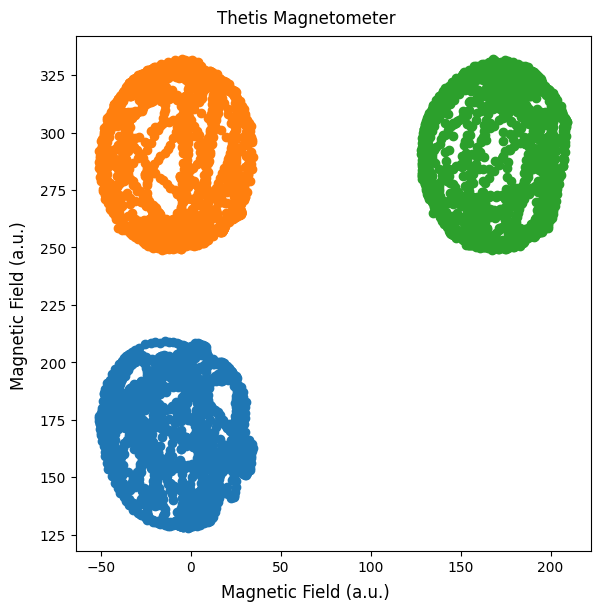

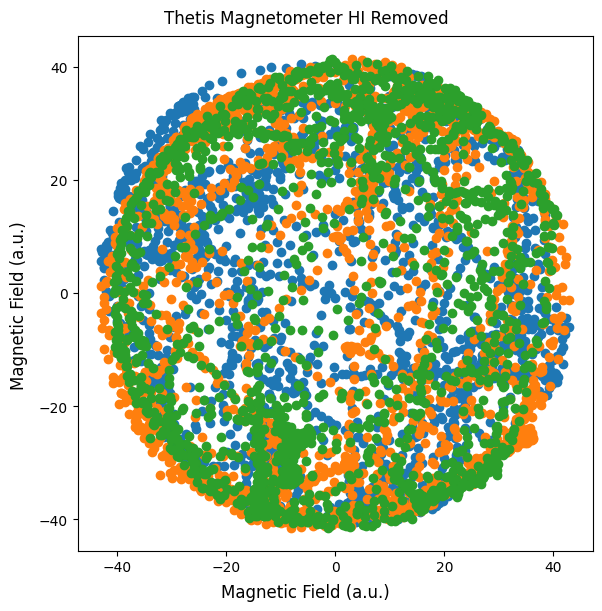

[[ 0.00722122 -0.00398562 -0.00493674]
 [-0.00398562  0.01000117 -0.00477361]
 [-0.00493674 -0.00477361  0.01058209]]
(2081, 3)
(2081, 3)


Text(0.02, 0.5, 'Magnetic Field (a.u.)')

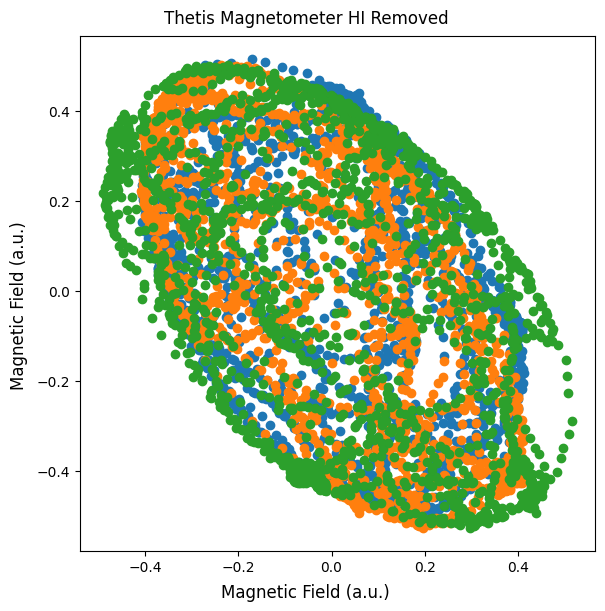

In [268]:
# Define the size of series windows
SAMPLE_RATE         = 20                            # Data captured at ~F Hz sample rate
WINDOW_SIZE_SEC     = 15                            # Capture ~N-seconds of data
WINDOW_SIZE = SAMPLE_RATE * WINDOW_SIZE_SEC         # Calculate number of indexes required for the window

for calibration_dataset in calibration_data:
    
    if not calibration_dataset["sensor_name"] == "Magnetometer": # Skip inertial datasets
        continue
    
    if not calibration_dataset["axis"] == "A": # Skip every data set but the "all axes" set
        continue
    
    # Determine the column number based on axis
    ax_names = ["X", "Y", "Z"]
    if calibration_dataset["axis"] == "X":
        ax_num = [1,2]
    elif calibration_dataset["axis"] == "Y":
        ax_num = [0,2]
    elif calibration_dataset["axis"] == "Z":
        ax_num = [0,1]
        
    for device in calibration_dataset["devices"]:
        
        # ========================================
        # == Clean The Raw Data For Each Device ==
        # ========================================
        
        # Load the CSV data into a DataFrame
        df = pd.read_csv(device["magnetic_csv_path"])
        df["Timestamp (us)"] = pd.to_datetime(df['Timestamp (us)'], unit='us')
        df.set_index("Timestamp (us)", inplace=True)
        # print(df) # Debug
        
        # if device["device_name"] == "Thetis": # Convert Thetis measurements from uT to a.u.
        #     df[["X Axis (a.u.)", "Y Axis (a.u.)", "Z Axis (a.u.)"]] /= np.linalg.norm(calibration_dataset["ground_truth_value"])
        
        # Save data to device dictionary before modification
        time_df = df.index
        data_df = df[["X Axis (a.u.)", "Y Axis (a.u.)", "Z Axis (a.u.)"]]
        
        device["raw_time"] = time_df.to_numpy()
        device["raw_data"] = data_df.to_numpy()
                
        # df = df[(np.abs(zscore(data_df.iloc[:, ax_num], nan_policy='omit')) < 3)] # Remove outliers according to Z-score
                        
        timestamps = df.index.to_numpy()
        data = df[["X Axis (a.u.)", "Y Axis (a.u.)", "Z Axis (a.u.)"]].to_numpy()
        
        # print(data) # Debug
                                
        device["cleaned_time"] = timestamps
        device["cleaned_data"] = data
        
        device["window_start"]  = int(len(data)/2) - int(WINDOW_SIZE/2)
        device["window_end"]    = device["window_start"] + WINDOW_SIZE
        device["windowed_time"] = timestamps[device["window_start"]:device["window_end"]]
        device["windowed_data"] = data[device["window_start"]:device["window_end"], :]
    
    # =================== 
    # == Plot Raw Data ==
    # ===================
    
    fig, axs = plt.subplots(1,2, figsize=(8, 4), layout='constrained')
    
    for i, ax in enumerate(axs):
        device = calibration_dataset["devices"][i]
        
        ax.scatter(device["cleaned_data"][:, 0], device["cleaned_data"][:, 1], label="XY")
        ax.scatter(device["cleaned_data"][:, 0], device["cleaned_data"][:, 2], label="XZ")
        ax.scatter(device["cleaned_data"][:, 1], device["cleaned_data"][:, 2], label="YZ")
        # ax.scatter(ximu3_device["cleaned_data"][0], ximu3_device["cleaned_data"][1], ximu3_device["cleaned_data"][2])
        # ax.set(aspect='equal')
        ax.set_box_aspect(1)
        ax.set_title(f"{device['device_name']}")
    
    fig.suptitle(f"Magnetometer Data | {calibration_dataset['ground_truth_name']}")
    fig.supxlabel("Magnetic Field (a.u.)")
    fig.supylabel("Magnetic Field (a.u.)")
    
    # plt.show()
    
    FIG_OUTPUT_PATH = RAW_OUTPUT_PATH + f"raw_{calibration_dataset['output_name']}.png"
    if not os.path.exists(FIG_OUTPUT_PATH): # Check if output already exists to save execution time
        fig.savefig(FIG_OUTPUT_PATH)
    plt.close(fig)
    
# ===============================================
# == Calculate and Remove Hard Iron Distortion ==
# ===============================================

mag_data = np.vstack([dataset["devices"][0]["cleaned_data"] for dataset in calibration_data if dataset["sensor_name"] == "Magnetometer" and dataset["axis"] == "A"])
# print(mag_data) # Debug

offset_x = (np.max(mag_data[:, 0]) + np.min(mag_data[:, 0])) / 2
offset_y = (np.max(mag_data[:, 1]) + np.min(mag_data[:, 1])) / 2
offset_z = (np.max(mag_data[:, 2]) + np.min(mag_data[:, 2])) / 2

hard_iron_offset = np.array([offset_x, offset_y, offset_z])
# print(hard_iron_offset) # Debug

mag_data_hid_removed = np.subtract(mag_data, hard_iron_offset)

fig, ax = plt.subplots(1,1, figsize=(6,6), layout='constrained')
ax.scatter(mag_data[:, 0], mag_data[:, 1], label="XY")
ax.scatter(mag_data[:, 0], mag_data[:, 2], label="XZ")
ax.scatter(mag_data[:, 1], mag_data[:, 2], label="YZ")
ax.set_box_aspect(1)

fig.suptitle("Thetis Magnetometer")
fig.supxlabel("Magnetic Field (a.u.)")
fig.supylabel("Magnetic Field (a.u.)")

fig, ax = plt.subplots(1,1, figsize=(6,6), layout='constrained')
ax.scatter(mag_data_hid_removed[:, 0], mag_data_hid_removed[:, 1], label="XY")
ax.scatter(mag_data_hid_removed[:, 0], mag_data_hid_removed[:, 2], label="XZ")
ax.scatter(mag_data_hid_removed[:, 1], mag_data_hid_removed[:, 2], label="YZ")
ax.set_box_aspect(1)

fig.suptitle("Thetis Magnetometer HI Removed")
fig.supxlabel("Magnetic Field (a.u.)")
fig.supylabel("Magnetic Field (a.u.)")

plt.show()

# FIG_OUTPUT_PATH = PRELIMINARY_OUTPUT_PATH + "mag_hard_iron_removed.png"
# if not os.path.exists(FIG_OUTPUT_PATH): # Check if output already exists to save execution time
#     fig.savefig(FIG_OUTPUT_PATH)

# Close the figures to save memory
plt.close(fig)

# ===============================================
# == Calculate and Remove Soft Iron Distortion ==
# ===============================================

def __ellipsoid_fit(s):
    ''' Estimate ellipsoid parameters from a set of points.

        Parameters
        ----------
        s : array_like
            The samples (M,N) where M=3 (x,y,z) and N=number of samples.

        Returns
        -------
        M, n, d : array_like, array_like, float
            The ellipsoid parameters M, n, d.

        References
        ----------
        .. [1] Qingde Li; Griffiths, J.G., "Least squares ellipsoid specific
            fitting," in Geometric Modeling and Processing, 2004.
            Proceedings, vol., no., pp.335-340, 2004
    '''
    from scipy import linalg
    
    # D (samples)
    D = np.array([s[0]**2., s[1]**2., s[2]**2.,
                    2.*s[1]*s[2], 2.*s[0]*s[2], 2.*s[0]*s[1],
                    2.*s[0], 2.*s[1], 2.*s[2], np.ones_like(s[0])])

    # S, S_11, S_12, S_21, S_22 (eq. 11)
    S = np.dot(D, D.T)
    S_11 = S[:6,:6]
    S_12 = S[:6,6:]
    S_21 = S[6:,:6]
    S_22 = S[6:,6:]

    # C (Eq. 8, k=4)
    C = np.array([[-1,  1,  1,  0,  0,  0],
                    [ 1, -1,  1,  0,  0,  0],
                    [ 1,  1, -1,  0,  0,  0],
                    [ 0,  0,  0, -4,  0,  0],
                    [ 0,  0,  0,  0, -4,  0],
                    [ 0,  0,  0,  0,  0, -4]])

    # v_1 (eq. 15, solution)
    E = np.dot(linalg.inv(C),
                S_11 - np.dot(S_12, np.dot(linalg.inv(S_22), S_21)))

    E_w, E_v = np.linalg.eig(E)

    v_1 = E_v[:, np.argmax(E_w)]
    if v_1[0] < 0: v_1 = -v_1

    # v_2 (eq. 13, solution)
    v_2 = np.dot(np.dot(-np.linalg.inv(S_22), S_21), v_1)

    # quadric-form parameters
    M = np.array([[v_1[0], v_1[3], v_1[4]],
                    [v_1[3], v_1[1], v_1[5]],
                    [v_1[4], v_1[5], v_1[2]]])
    n = np.array([[v_2[0]],
                    [v_2[1]],
                    [v_2[2]]])
    d = v_2[3]

    return M, n, d

M, n, d = __ellipsoid_fit(mag_data_hid_removed)


from scipy import linalg
M_1 = linalg.inv(M)
b = -np.dot(M_1, n)
A_1 = np.real(1.0 / np.sqrt(np.dot(n.T, np.dot(M_1, n)) - d) * linalg.sqrtm(M))

print(A_1)

# A_1_mc = np.matmul(A_1, mag_data[:, :, np.newaxis])
# print(A_1.shape)
# print(mag_data[:, :, np.newaxis].T.shape)
# cal_mag_data = np.array([np.subtract(np.multiply(A_1, measurement), hard_iron_offset) for measurement in mag_data])
# print(np.squeeze(A_1_mc, axis=-1))
cal_mag_data = np.matmul((mag_data - hard_iron_offset), A_1)
print(np.matmul(mag_data, A_1).shape)
print(cal_mag_data.shape)

fig, ax = plt.subplots(1,1, figsize=(6,6), layout='constrained')
ax.scatter(cal_mag_data[:, 0], cal_mag_data[:, 1], label="XY")
ax.scatter(cal_mag_data[:, 0], cal_mag_data[:, 2], label="XZ")
ax.scatter(cal_mag_data[:, 1], cal_mag_data[:, 2], label="YZ")
ax.set_box_aspect(1)

fig.suptitle("Thetis Magnetometer HI Removed")
fig.supxlabel("Magnetic Field (a.u.)")
fig.supylabel("Magnetic Field (a.u.)")

